In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

In [50]:
from glob import glob
import matplotlib.pyplot as plt
dataset_path = "./data/*"
path_files = glob(dataset_path)
path_files = [x.replace("\\","/") for x in path_files]
path_files

['./data/constant_jammer.txt',
 './data/normal_channel.txt',
 './data/random_jammer.txt']

In [51]:
signal_size = 1000
label_map = {"random_jammer" : 0,"normal_channel" : 1,"constant_jammer" : 2}
def preprocess_data(path_files):
    X = []
    y = []
    for path_file in path_files:
        filename = path_file.split("/")[-1][:-4]
        label = label_map[filename]
        with open(path_file, "r") as f:
            signals = np.reshape(f.read().split("\n"),(410,1000))
        for signal in signals:
            X.append(signal)
            y.append(label)
    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="int8")
    return X, y
X, y = preprocess_data(path_files)

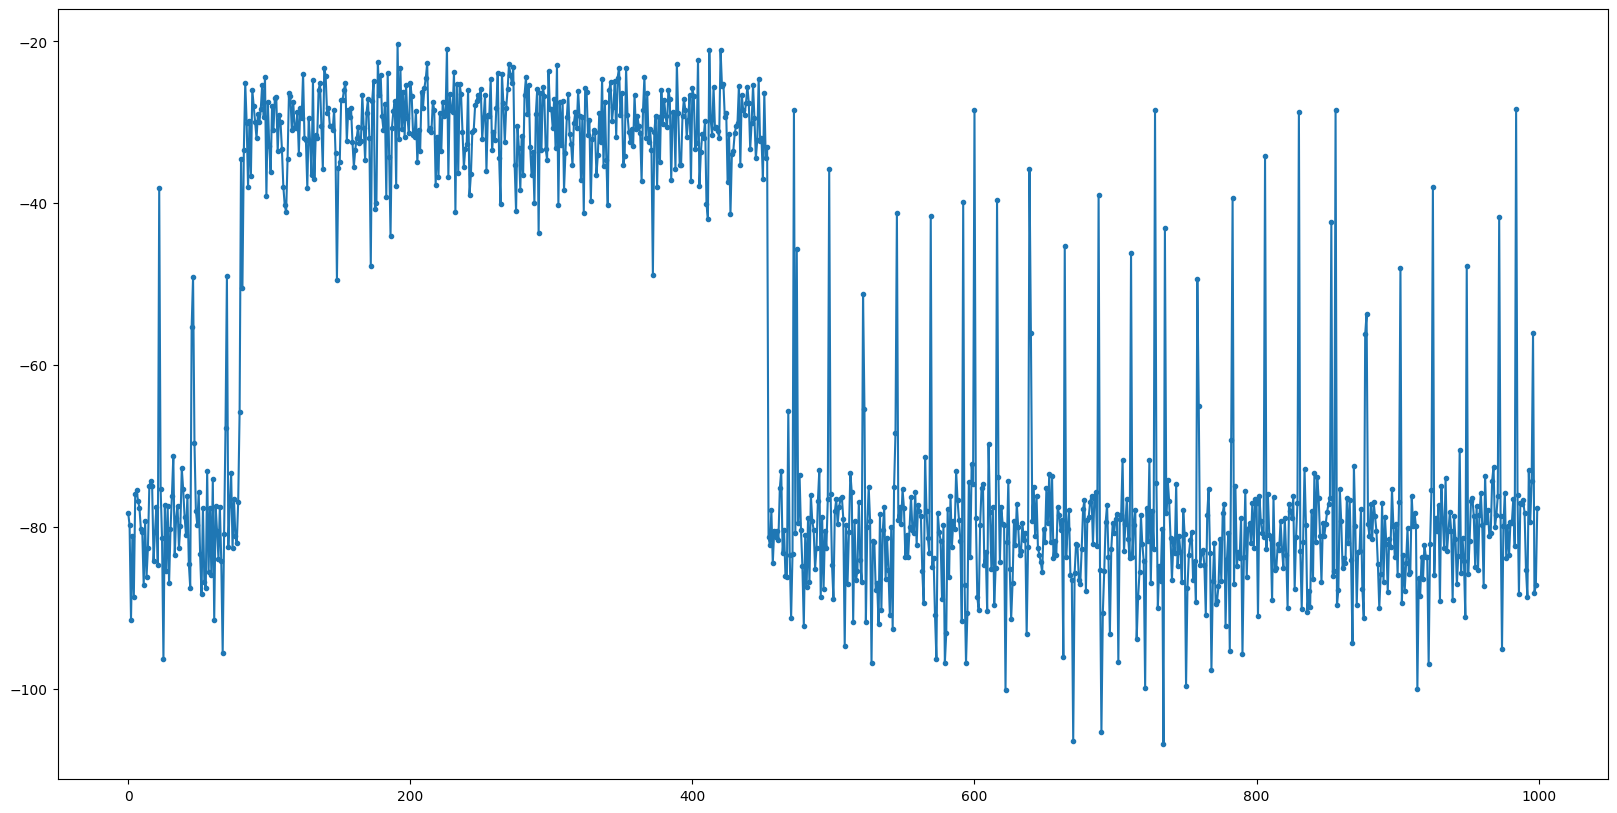

In [52]:
x = np.linspace(start = 0, stop = 1000, num = 1)
random = X[3][:]
plt.figure(figsize=(20,10))
plt.plot(random, marker='.')

In [53]:
max_abs_value = np.amax(np.abs(X))
X/=max_abs_value
print(max_abs_value)

143.7464


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100/410, random_state=42, stratify=y)
y_train = to_categorical(y_train, num_classes=3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, 
                                                      random_state=42, stratify=y_train)

In [55]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 50

## Load LSTM Model

In [56]:
import cv2
SGN_SIZE = 224
def reshape_signal(signal, label=None):
    signal = tf.reshape(signal, (10, 100))
#     resized_image = tf.image.resize(signal, [224, 224], method=tf.image.ResizeMethod.BICUBIC)
#     resized_image_with_channels = tf.image.grayscale_to_rgb(resized_image)
    
    if label is None:
        return signal
    else:
        return signal, label

train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(100000)
    .cache()
    .map(reshape_signal, num_parallel_calls=AUTO)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .map(reshape_signal, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid, y_valid))
    .cache()
    .map(reshape_signal, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [57]:
interpreter = tf.lite.Interpreter(model_path="jamming-bilstm.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details for verification
print("Input Details:", input_details)
print("Output Details:", output_details)

Input Details: [{'name': 'serving_default_bidirectional_input:0', 'index': 0, 'shape': array([  1,  10, 100]), 'shape_signature': array([ -1,  10, 100]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 102, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [58]:
import numpy as np

def run_inference_on_dataset(interpreter, dataset):
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    
    predictions = []

    for batch in dataset:
        for input_data in batch:
            # Ensure input data is in the correct shape and dtype
            input_data = np.expand_dims(input_data, axis=0)
            interpreter.set_tensor(input_index, input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_index)
            predictions.append(output_data)
    
    return predictions

predictions = run_inference_on_dataset(interpreter, test_dataset)

### Detection metrix

In [59]:
y_prob = np.array(predictions)
y_prob = np.squeeze(y_prob, axis=1)
y_pred = np.argmax(y_prob, axis=1)

y_pred[y_pred==1] = 3
y_pred[(y_pred == 0) | (y_pred == 2)] = 1
y_pred[y_pred==3] = 0
y_test_det = y_test.copy()
y_test_det[y_test_det==1] = 3
y_test_det[(y_test_det == 0) | (y_test_det == 2)] = 1
y_test_det[y_test_det==3] = 0
clf_report = metrics.classification_report(y_test_det, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test_det, y_pred)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9800    0.9800    0.9800       100
           1     0.9900    0.9900    0.9900       200

    accuracy                         0.9867       300
   macro avg     0.9850    0.9850    0.9850       300
weighted avg     0.9867    0.9867    0.9867       300

[[ 98   2]
 [  2 198]]


### Classification Metrix

In [60]:
y_prob = np.array(predictions)
y_prob = np.squeeze(y_prob, axis=1)
y_pred = np.argmax(y_prob, axis=1)
indices = np.where((y_test != 1) & (y_pred != 1))[0]
# print(y_test)
y_test_clf = y_test[indices]
y_pred_clf = y_pred[indices]

# Chuyển các giá trị 2 thành 1
y_test_clf[y_test_clf == 2] = 1
y_pred_clf[y_pred_clf == 2] = 1
clf_report = metrics.classification_report(y_test_clf, y_pred_clf, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test_clf, y_pred_clf)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9515    1.0000    0.9751        98
           1     1.0000    0.9500    0.9744       100

    accuracy                         0.9747       198
   macro avg     0.9757    0.9750    0.9747       198
weighted avg     0.9760    0.9747    0.9747       198

[[98  0]
 [ 5 95]]


## EfficientNet

In [61]:
signal_size = 1000
label_map = {"random_jammer" : 0,"normal_channel" : 1,"constant_jammer" : 2}
def preprocess_data(path_files):
    X = []
    y = []
    for path_file in path_files:
        filename = path_file.split("/")[-1][:-4]
        label = label_map[filename]
        with open(path_file, "r") as f:
            signals = np.reshape(f.read().split("\n"),(410,1000))
        for signal in signals:
            X.append(signal)
            y.append(label)
    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="int8")
    return X, y
X, y = preprocess_data(path_files)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100/410, random_state=42, stratify=y)
y_train = to_categorical(y_train, num_classes=3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, 
                                                      random_state=42)

In [62]:
import cv2
SGN_SIZE = 224
def reshape_signal(signal, label=None):
    signal = tf.reshape(signal, (100, 10, 1))
    resized_image = tf.image.resize(signal, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_image_with_channels = tf.image.grayscale_to_rgb(resized_image)
    
    if label is None:
        return resized_image_with_channels
    else:
        return resized_image_with_channels, label

train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(100000)
    .cache()
    .map(reshape_signal, num_parallel_calls=AUTO)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .map(reshape_signal, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid, y_valid))
    .cache()
    .map(reshape_signal, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [63]:
interpreter = tf.lite.Interpreter(model_path="jamming-efficientnetb0.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details for verification
print("Input Details:", input_details)
print("Output Details:", output_details)

Input Details: [{'name': 'serving_default_efficientnet-b0_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 482, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [64]:
import numpy as np

def run_inference_on_dataset(interpreter, dataset):
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    
    predictions = []

    for batch in dataset:
        for input_data in batch:
            # Ensure input data is in the correct shape and dtype
            input_data = np.expand_dims(input_data, axis=0)
            interpreter.set_tensor(input_index, input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_index)
            predictions.append(output_data)
    
    return predictions

predictions = run_inference_on_dataset(interpreter, test_dataset)

### Detection metric

In [65]:
y_prob = np.array(predictions)
y_prob = np.squeeze(y_prob, axis=1)
y_pred = np.argmax(y_prob, axis=1)

y_pred[y_pred==1] = 3
y_pred[(y_pred == 0) | (y_pred == 2)] = 1
y_pred[y_pred==3] = 0
y_test_det = y_test.copy()
y_test_det[y_test_det==1] = 3
y_test_det[(y_test_det == 0) | (y_test_det == 2)] = 1
y_test_det[y_test_det==3] = 0
clf_report = metrics.classification_report(y_test_det, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test_det, y_pred)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9800    0.9800    0.9800       100
           1     0.9900    0.9900    0.9900       200

    accuracy                         0.9867       300
   macro avg     0.9850    0.9850    0.9850       300
weighted avg     0.9867    0.9867    0.9867       300

[[ 98   2]
 [  2 198]]


### Classification metric

In [66]:
y_prob = np.array(predictions)
y_prob = np.squeeze(y_prob, axis=1)
y_pred = np.argmax(y_prob, axis=1)
indices = np.where((y_test != 1) & (y_pred != 1))[0]
# print(y_test)
y_test_clf = y_test[indices]
y_pred_clf = y_pred[indices]

# Chuyển các giá trị 2 thành 1
y_test_clf[y_test_clf == 2] = 1
y_pred_clf[y_pred_clf == 2] = 1
clf_report = metrics.classification_report(y_test_clf, y_pred_clf, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test_clf, y_pred_clf)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9515    1.0000    0.9751        98
           1     1.0000    0.9500    0.9744       100

    accuracy                         0.9747       198
   macro avg     0.9757    0.9750    0.9747       198
weighted avg     0.9760    0.9747    0.9747       198

[[98  0]
 [ 5 95]]


## MobileNet

In [68]:
interpreter = tf.lite.Interpreter(model_path="jamming-mobilenet.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details for verification
print("Input Details:", input_details)
print("Output Details:", output_details)

Input Details: [{'name': 'serving_default_mobilenetv2_1.00_224_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 181, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [69]:
import numpy as np

def run_inference_on_dataset(interpreter, dataset):
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    
    predictions = []

    for batch in dataset:
        for input_data in batch:
            # Ensure input data is in the correct shape and dtype
            input_data = np.expand_dims(input_data, axis=0)
            interpreter.set_tensor(input_index, input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_index)
            predictions.append(output_data)
    
    return predictions

predictions = run_inference_on_dataset(interpreter, test_dataset)

### Detection metric

In [70]:
y_prob = np.array(predictions)
y_prob = np.squeeze(y_prob, axis=1)
y_pred = np.argmax(y_prob, axis=1)

y_pred[y_pred==1] = 3
y_pred[(y_pred == 0) | (y_pred == 2)] = 1
y_pred[y_pred==3] = 0
y_test_det = y_test.copy()
y_test_det[y_test_det==1] = 3
y_test_det[(y_test_det == 0) | (y_test_det == 2)] = 1
y_test_det[y_test_det==3] = 0
clf_report = metrics.classification_report(y_test_det, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test_det, y_pred)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9800    0.9800    0.9800       100
           1     0.9900    0.9900    0.9900       200

    accuracy                         0.9867       300
   macro avg     0.9850    0.9850    0.9850       300
weighted avg     0.9867    0.9867    0.9867       300

[[ 98   2]
 [  2 198]]


### Classification metric

In [71]:
y_prob = np.array(predictions)
y_prob = np.squeeze(y_prob, axis=1)
y_pred = np.argmax(y_prob, axis=1)
indices = np.where((y_test != 1) & (y_pred != 1))[0]
# print(y_test)
y_test_clf = y_test[indices]
y_pred_clf = y_pred[indices]

# Chuyển các giá trị 2 thành 1
y_test_clf[y_test_clf == 2] = 1
y_pred_clf[y_pred_clf == 2] = 1
clf_report = metrics.classification_report(y_test_clf, y_pred_clf, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test_clf, y_pred_clf)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9515    1.0000    0.9751        98
           1     1.0000    0.9500    0.9744       100

    accuracy                         0.9747       198
   macro avg     0.9757    0.9750    0.9747       198
weighted avg     0.9760    0.9747    0.9747       198

[[98  0]
 [ 5 95]]
